In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Important assumptions of linear regression: 

1. Linearity: There must be linear relationship between each independent variables with dependent variable.
2. Homoscedasticity: The variance of error terms is similar across independent variables.
3. Multivariate normality: The residuals are normally distributed. This assumption is tested by variance inflation factor.
4. Independence of errors: The errors are not dependent among samples. Possible influences on the data are repeated sample size or time series data.
5. Lack of multicollinearity: For the case of simple collinearity, it could be detected with correlation coefficient between different pair of variables. However, if collinearity exist between three to more variables, correlation coefficient may not uncover it. We call this situation multi-collinearity. A better way to evaluate multicollinearity in this case is to compute the variance inflation factor (VIF). A VIF factor between 5 - 10 indicating multicollinearity. 

$VIF(\hat{\beta}_{j}) = \frac{1}{1-R^2_{X_{j}|X_{-j}}}$

Here $R^2_{X_{j}|X_{-j}}$ is the $R^2$ of fitted predicting the jth variable using the rest varaibles

6. Outliers: Outlier could be identified with studentized residuals: $ SR = \frac{e_{i}}{SE} > 3$
7. High leverage points: Leverage statistic of a data could be computed by: $h_{i} = \frac{1}{n} + \frac{(x_{i}-\bar{x})^2}{\sum{(x_{i}'-\bar {x})^2}}$

Before performing MLR, we need to test the assumptions whether it is proper to use the multilinear regression.

A rule of thumb for deciding sample sizes for performing multilinear regression is that at least 20 per independent variable.

In [2]:
# Import the data
data = pd.read_csv('50_Startups.csv')

In [3]:
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
# Seperate into independent and dependent variable
X = data.iloc[:,:4]
y = data.iloc[:, -1]

In [5]:
# Perform one hot encoding on State variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
X['State'] = le.fit_transform(X['State'])

In [6]:
onehot = pd.get_dummies(X['State'], drop_first=True, prefix='State')
X = X.join(onehot)
X.drop(labels='State', axis=1, inplace=True)

In [7]:
X.head()

,R&D Spend,Administration,Marketing Spend,State_1,State_2
0,165349.20,136897.80,471784.10,0,1
1,162597.70,151377.59,443898.53,0,0
2,153441.51,101145.55,407934.54,1,0
3,144372.41,118671.85,383199.62,0,1
4,142107.34,91391.77,366168.42,1,0


### 1. Multilinear regression requires that relationship between independent and dependent variables must be linear.

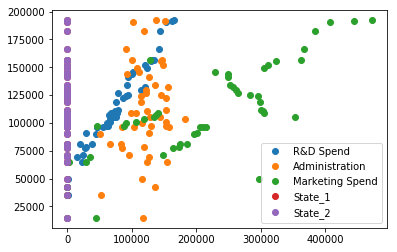

In [8]:
# Test if dependent and independent variables have curvilinear relationship
for i in range(len(X.columns)):
    plt.plot(X[X.columns[i]], y, 'o', label=X.columns[i])
    
plt.legend()

### 2. Multilinear regression assumes that there is no muticollinearity in the data. 
This could be checked with the following three methods:
- Correlation matrix: When computing a matrix of Pearson's bivariate correlations among all independent variables, the magnitude of the correlation coeffection should be less than 0.8

In [9]:
X.corr()

,R&D Spend,Administration,Marketing Spend,State_1,State_2
R&D Spend,1.000000,0.241955,0.724248,0.105711,0.039068
Administration,0.241955,1.000000,-0.032154,0.010493,0.005145
Marketing Spend,0.724248,-0.032154,1.000000,0.205685,-0.033670
State_1,0.105711,0.010493,0.205685,1.000000,-0.492366
State_2,0.039068,0.005145,-0.033670,-0.492366,1.000000


We could also calculate the pearson's correlation coefficient by hand using the definition:

$corr coef = \frac{(X-X_{mean})(y-y_{mean})}{(n-1)x_{std}y_{std}}$

In [10]:
Corr_RD_Administration = np.dot((X.iloc[:,0]-X.iloc[:,0].mean()), (X.iloc[:,1]-X.iloc[:,1].mean()))

In [11]:
Corr_RD_Administration = Corr_RD_Administration/X.iloc[:,0].std()/X.iloc[:,1].std()/(len(X)-1)

In [12]:
Corr_RD_Administration

0.24195524508168917

- Variance Inflation Factor (VIF): The VIFs of the linear regression indicate the degree that variances in the regression are increased due to multicollinearity. VIF bigger than 5 is considered that the ordinary least square estimation has been influenced by the multicollinearity.

If it is possible to identify factors that are causing multicollinearity, you could remove it directly from the explanatory variables. If not, centers the variables will likely help. 

After fitting the model, there are additional two variables that we need to check: 
- The multilinear regression requires that errors between the observed and predicted values should be normally distributed. This could be checked by looking at the histogram or the QQ plot.
- The multilinear regression assumes that the variance of residual error will not depends on the dependent variable, that is no homoscedasticity. This could be checked by plotting the residual error after fitting as a function of dependent variable.

Now let's fit a multiliear regression model with sklearn
We need first to decide which independent variables to use. And there are five options that we could try:
1. ### All - in:
    - Prior knowledge that all variables are useful
    - Preparing for backward elimination
2. ### Backward Elimination:
    - Select the significance level to stay in the model ($ \alpha = 0.05$, probability that the model is obtained by chance)
    - Fit the full model with all possible predictors
    - Consider the predictor with highest P-value, if P > SL, remove the variable
    - Refit the model after removing the variable
    - Repeat the steps until all the p values are below the SL
    - Backward elimination could not be used if p>n
3. ### Forward Selection
    - Select a significance level (0.05)
    - Fit all single regression model for the target variable, select the one with lowest P-value
    - Keep this variable and fit all possible model with one extra predictor, select the one with lowest P-value
    - Repeat the above steps until p value stops decreasing
4. ### Bidirectional Selection
    - Select a significance level (0.05)
    - Perform the next step of forward selection
    - Perform all steps of backward elimination
    - Until no variables could be added or removed
5. ### Score Comparison: Not too practical
    - Select a criterion of goodness of fit (e.g, Akaike criterion)
    - Construct all possible regression models : 2^N - 1
    - Select the one with best criterion

Here we will use the backward elimination, which is the fastest one

In [13]:
# We will first seperate the data into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Pay attention that nor feature scaling is necessary, given that the library will take it.

In [14]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
# Test the performance of the model
y_pred = regressor.predict(X_test)

In [16]:
# Find the optimal model with backward elimination
import statsmodels.formula.api as sm

In [17]:
# Pay attention that for stats model, it doesn't add the b0 term with x0 = 1
# We need to add the column of ones
X_train['Constant'] = np.ones((len(X_train), 1)).astype(int)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
X_train.head()

,R&D Spend,Administration,Marketing Spend,State_1,State_2,Constant
33,55493.95,103057.49,214634.81,1,0,1
35,46014.02,85047.44,205517.64,0,1,1
26,75328.87,144135.98,134050.07,1,0,1
34,46426.07,157693.92,210797.67,0,0,1
18,91749.16,114175.79,294919.57,1,0,1


In [30]:
# Performing backwward elimination
X_opt = np.array(X_train)[:, [0,1,2,3,4,5]]
# Fit the multilinear regression with ols object
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     129.7
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           3.91e-21
Time:                        20:35:24   Log-Likelihood:                -421.10
No. Observations:                  40   AIC:                             854.2
Df Residuals:                      34   BIC:                             864.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7735      0.055     14.025      0.000       0.661       0.886
x2             0.0329      0.066      0.495      0.624      -0.102       0.168
x3             0.0366      0.019      1.884      0.068      -0.003       0.076
x4          -959.2842   4038.108     -0.238      0.814   -9165.706    7247.138
x5           699.3691   3661.563      0.191      0.850   -6741.822    8140.560
const       4.255e+04   8358.538      5.091      0.000    2.56e+04    5.95e+04
==============================================================================
Omnibus:                       15.823   Durbin-Watson:                   2.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.231
Skew:                          -1.094   Prob(JB):                     9.03e-06
Kurtosis:                       6.025   Cond. No.                     1.49e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# Performing backwward elimination
X_opt = np.array(X_train)[:, [0,1,2,3,5]]
# Fit the multilinear regression with ols object
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     166.7
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           2.87e-22
Time:                        20:35:31   Log-Likelihood:                -421.12
No. Observations:                  40   AIC:                             852.2
Df Residuals:                      35   BIC:                             860.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7754      0.053     14.498      0.000       0.667       0.884
x2             0.0319      0.065      0.488      0.629      -0.101       0.165
x3             0.0363      0.019      1.902      0.065      -0.002       0.075
x4         -1272.1608   3639.780     -0.350      0.729   -8661.308    6116.986
const       4.292e+04   8020.397      5.352      0.000    2.66e+04    5.92e+04
==============================================================================
Omnibus:                       16.074   Durbin-Watson:                   2.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.553
Skew:                          -1.086   Prob(JB):                     4.66e-06
Kurtosis:                       6.164   Cond. No.                     1.43e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
# Performing backwward elimination
X_opt = np.array(X_train)[:, [0,1,2,5]]
# Fit the multilinear regression with ols object
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     227.8
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           1.85e-23
Time:                        20:35:42   Log-Likelihood:                -421.19
No. Observations:                  40   AIC:                             850.4
Df Residuals:                      36   BIC:                             857.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7788      0.052     15.003      0.000       0.674       0.884
x2             0.0294      0.064      0.458      0.650      -0.101       0.160
x3             0.0347      0.018      1.896      0.066      -0.002       0.072
const       4.299e+04   7919.773      5.428      0.000    2.69e+04    5.91e+04
==============================================================================
Omnibus:                       15.557   Durbin-Watson:                   2.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.539
Skew:                          -1.081   Prob(JB):                     1.28e-05
Kurtosis:                       5.974   Cond. No.                     1.43e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# Performing backwward elimination
X_opt = np.array(X_train)[:, [0,2,5]]
# Fit the multilinear regression with ols object
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     349.0
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           9.65e-25
Time:                        20:35:55   Log-Likelihood:                -421.30
No. Observations:                  40   AIC:                             848.6
Df Residuals:                      37   BIC:                             853.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7886      0.047     16.846      0.000       0.694       0.883
x2             0.0326      0.018      1.860      0.071      -0.003       0.068
const       4.635e+04   2971.236     15.598      0.000    4.03e+04    5.24e+04
==============================================================================
Omnibus:                       14.666   Durbin-Watson:                   2.518
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.582
Skew:                          -1.030   Prob(JB):                     3.39e-05
Kurtosis:                       5.847   Cond. No.                     4.97e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Performing backwward elimination
X_opt = np.array(X_train)[:, [0, 5]]
# Fit the multilinear regression with ols object
regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     652.4
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           1.56e-25
Time:                        20:36:03   Log-Likelihood:                -423.09
No. Observations:                  40   AIC:                             850.2
Df Residuals:                      38   BIC:                             853.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8516      0.033     25.542      0.000       0.784       0.919
const       4.842e+04   2842.717     17.032      0.000    4.27e+04    5.42e+04
==============================================================================
Omnibus:                       13.132   Durbin-Watson:                   2.325
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.254
Skew:                          -0.991   Prob(JB):                     0.000295
Kurtosis:                       5.413   Cond. No.                     1.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Pay atten that during the last step of feature selection, the p value was 0.06, which is very close to our threshold value = 0.05. Wheter it is a good idea to remove the variable could be further evaluated using R-squared or Adjusted R-squared.

In [43]:
# Our final model contains the parameters:
X_final = pd.DataFrame(X['R&D Spend'])

X_train_final, X_test_final, y_train, y_test = train_test_split(X_final, y, test_size=0.1, random_state=0)

regressor.fit(X_train_final, y_train)
b1 = regressor.coef_
b2 = regressor.intercept_

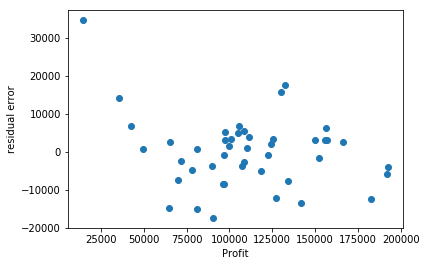

In [46]:
# Test homoscecasdicity
y_pred = regressor.predict(X_train_final)
residul = y_pred - y_train
plt.plot(y_train, residul, 'o')
plt.xlabel('Profit')
plt.ylabel('residual error')

Form the above plot we could see that there is likely not homoscesdicity.

The next thing we need to check is whether there is the residual error is normaly distributed

(array([  3.,   2.,   1.,   4.,   3.,   5.,   4.,  11.,   5.,   3.,   0.,
          0.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-17337.88332237, -14741.60961992, -12145.33591746,  -9549.06221501,
         -6952.78851255,  -4356.5148101 ,  -1760.24110764,    836.03259481,
          3432.30629727,   6028.57999972,   8624.85370218,  11221.12740463,
         13817.40110709,  16413.67480954,  19009.948512  ,  21606.22221445,
         24202.49591691,  26798.76961936,  29395.04332182,  31991.31702427,
         34587.59072673]),
 <a list of 20 Patch objects>)

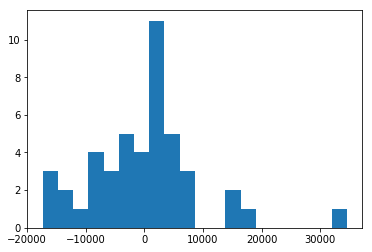

In [49]:
# Plot the histogram of residual error
plt.hist(residul, bins=20)

In [55]:
# Generate QQ plot
import numpy as np
import statsmodels.api as sm
import pylab

# We need first to normalize the residual
residul = (residul-residul.mean())/residul.std()

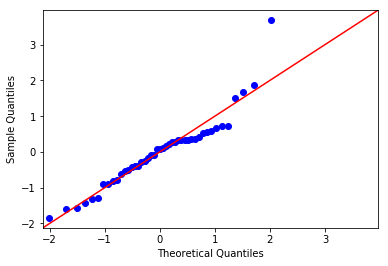

In [57]:
sm.qqplot(residul, line='45')
pylab.show()

### Model evaluation


To evaluate the goodness of fitting, we hope to compare the residual variance to the original variance of the target variables. Two of the important measures are R squared and adjusted R squared

$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

Given that ordinary least square aims in minimizing the sum of squared residual, putting more independent variables will only lead to increase in the R squared. To penalize the increase of independent variabls, we use adjusted sum of squared:

Ajusted $R^2 = 1 - (1 - R^2) \frac {n-1}{n-p-1}$

### Some important questions

#### 1. Is at least one of the predictors X1, X2, ..., Xp useful in predicting the response?

To answer the question, we could either use the t-statistic to test the null hypothesis for relation between each independnet variable and dependent variable. However, when the number of independent variable is large, there is a high probability that we will have false positive testing result. Therefore, instead of performing the test individally, we will construct the F statistic and combines all the parameters together.The constructed F statistic is as followes:

$ F = \frac{(TSS - RSS)/p}{RSS/(n-p-1)}$

Although the F statistic looks complicated, what we need to keep in mind is that we will reject the null hypothesis that none of the parameter contributes to explaining the target variable if F is way bigger than 1.

#### 2. Deciding on Important Variables

Various statistics can be used to judge the quality of the model:
- Mallow's Cp
- Alkaike Information (AIC)
- Bayesian Information (BIC)
- Ajusted R2

The general approach include forward, backward and mix model selection.

#### 3. For multilinear regression, we need to consider if higher order interaction variable should be included